In [1]:
import itertools
import operator
from typing import Callable

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import polars as pl
import seaborn as sns
from scipy import stats

try:
    import pingouin as pg
except ModuleNotFoundError:
    # pingouin installation doesn't work via poetry for some reason.
    %pip install pingouin
    import pingouin as pg

from lib import (
    binned,
    load_dataset,
    compute_accuracy_results,
    process_parameter_dataset,
    compute_runtime_validity_results,
    process_runtime_dataset,
    set_legend_line_width,
    make_boxplot,
    validate_parameter_dataset,
    apply_hypothesis_test,
    save_figure,
    save_table,
    normalized,
    format_network_types,
)

## Experiment 1: Parameters

In [2]:
df = load_dataset("send-coefficient")
validate_parameter_dataset(df)

In [3]:
data = process_runtime_dataset(df, keep_burn_in=True)
data = compute_runtime_validity_results(data)
data = format_network_types(data)
data

network_type,count,proportion
str,u32,f64
"""Barabasi-Albert""",520,1.0
"""Erdös–Rényi""",520,1.0
"""Random regular""",520,1.0
"""Watts-Strogatz""",520,1.0


In [9]:
parameter = "send_coefficient"
parameter_title = "Send coefficient"
parameter_symbol = "\gamma"

results = compute_accuracy_results(
    process_parameter_dataset(df),
    parameter=parameter,
    tabular_percentiles=[0, 0.01, 0.1, *range(1, 7), 21],
    # Ref: https://en.wikipedia.org/wiki/Seven-number_summary#Bowley%E2%80%99s_seven-figure_summary
    count_percentiles=[0, 10, 25, 50, 75, 90, 100],
)

min_parameter = results.counts[parameter].min()


def filter_min_parameter(__df: pl.DataFrame, op: Callable) -> pl.DataFrame:
    return __df.filter(op(pl.col(parameter), min_parameter))

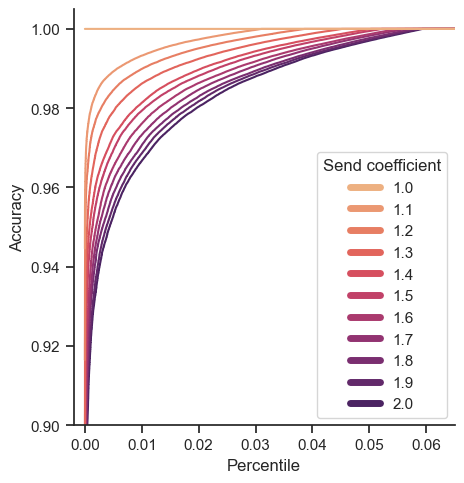

In [5]:
data = filter_min_parameter(results.tabular, operator.ge)

sns.set_theme(style="ticks", font_scale=1)

g = sns.displot(
    data,
    kind="ecdf",
    y="accuracy",
    hue=parameter,
    palette="flare",
    facet_kws={"legend_out": False},
)

g.set_axis_labels("Percentile", "Accuracy")
g.set(xlim=(-0.002, 0.065), ylim=(0.90, 1.005))
g.legend.set_title(parameter_title)
set_legend_line_width(g, 5)

output_path = "outputs/accuracy_aggregate"
save_figure(output_path)
save_table(results.tabular_percentiles.aggregate, output_path)

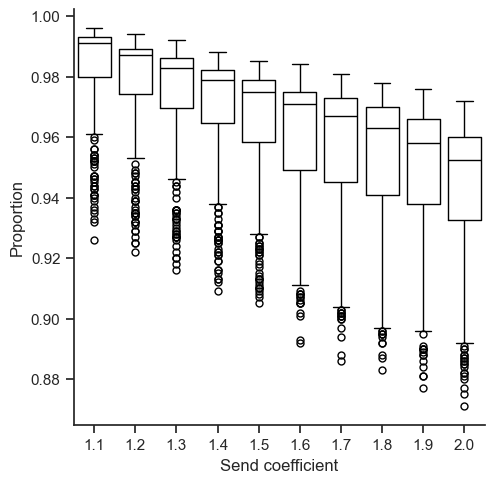

In [6]:
data = filter_min_parameter(results.counts, operator.gt)

sns.set_theme(style="ticks", font_scale=1)

g = make_boxplot(data, x=parameter, y="proportion", sharey=False, by_network_type=False)

g.set_axis_labels("Send coefficient", "Proportion")

output_path = "outputs/accuracy_lifted_aggregate"
save_figure(output_path)
save_table(results.count_percentiles.aggregate, output_path)

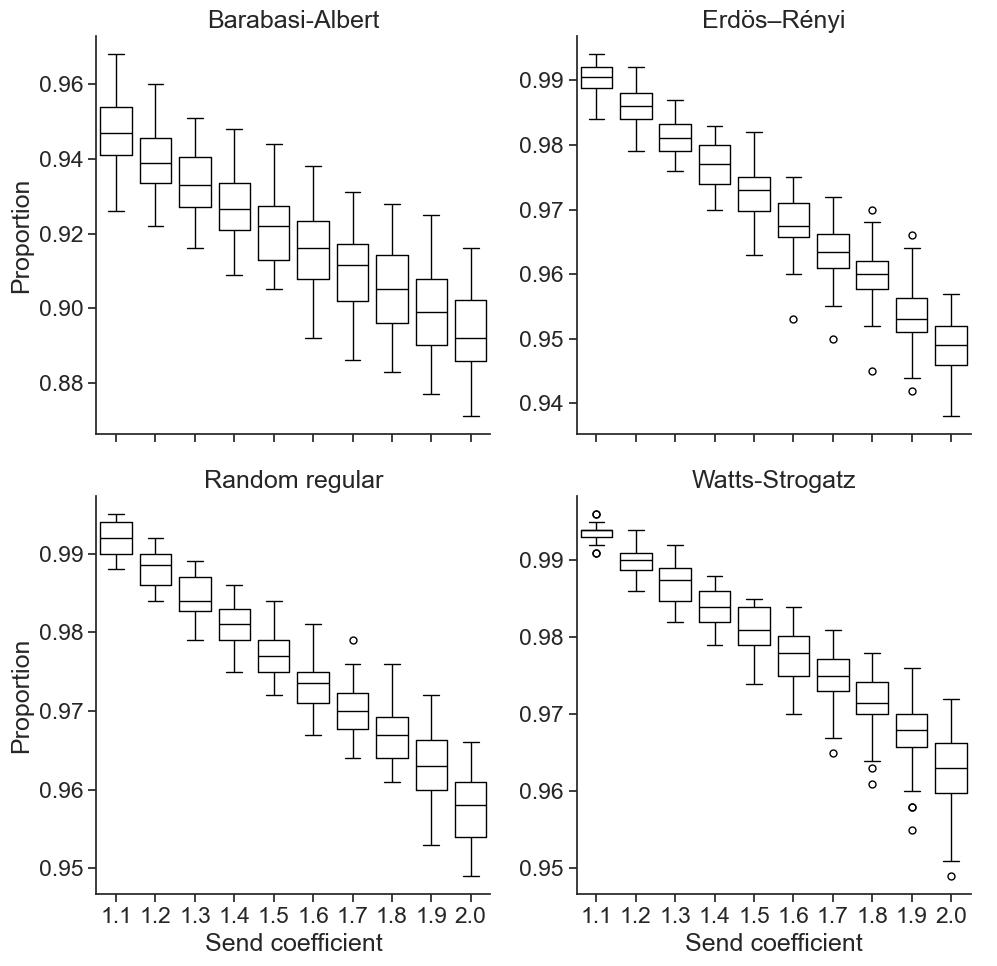

In [4]:
data = filter_min_parameter(results.counts, operator.gt)

sns.set_theme(style="ticks", font_scale=1.5)

g = make_boxplot(data, x=parameter, y="proportion", sharey=False, by_network_type=True)

g.set_axis_labels("Send coefficient", "Proportion")

output_path = "outputs/accuracy_lifted_network-type"
save_figure(output_path)
save_table(format_network_types(results.count_percentiles.network_type), output_path)

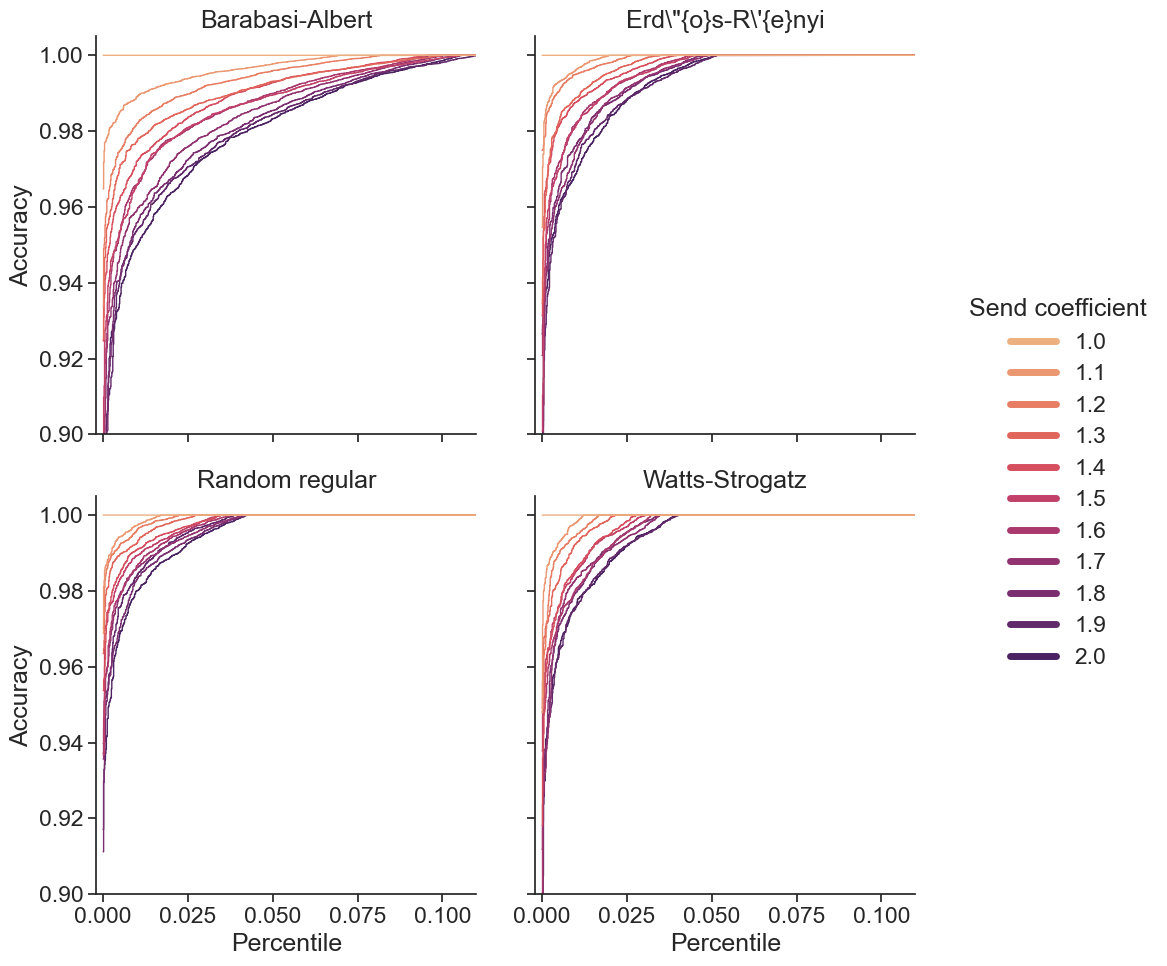

In [5]:
data = filter_min_parameter(results.tabular, operator.ge)
data = data.sample(fraction=0.05)
data = format_network_types(data)

sns.set_theme(style="ticks", font_scale=1.5)

g = sns.displot(
    data,
    kind="ecdf",
    y="accuracy",
    col="network_type",
    col_wrap=2,
    col_order=data["network_type"].unique().sort(),
    hue=parameter,
    linewidth=1,
    palette="flare",
)

g.set(xlim=(-0.002, 0.11), ylim=(0.90, 1.005))
g.set_axis_labels("Percentile", "Accuracy")
g.set_titles("{col_name}")
g.legend.set_title(parameter_title)
set_legend_line_width(g, 5)

save_figure("outputs/accuracy_network-type")

In [ ]:
data = filter_min_parameter(df, operator.ge)

data = (
    data.with_columns(pl.col("n_receives").list.sum())
    .with_columns(
        normalized("n_receives", by="max")
        .over("dataset_id", "network_id", "score_source")
        .alias("normalized_n_receives")
    )
    .filter(pl.col(parameter) > min_parameter)
    .to_pandas()
)

g = make_boxplot(data, x=parameter, y="normalized_n_receives")

g.set_axis_labels(parameter_title, "Relative messages recieved")

save_figure("outputs/received-boxplot")

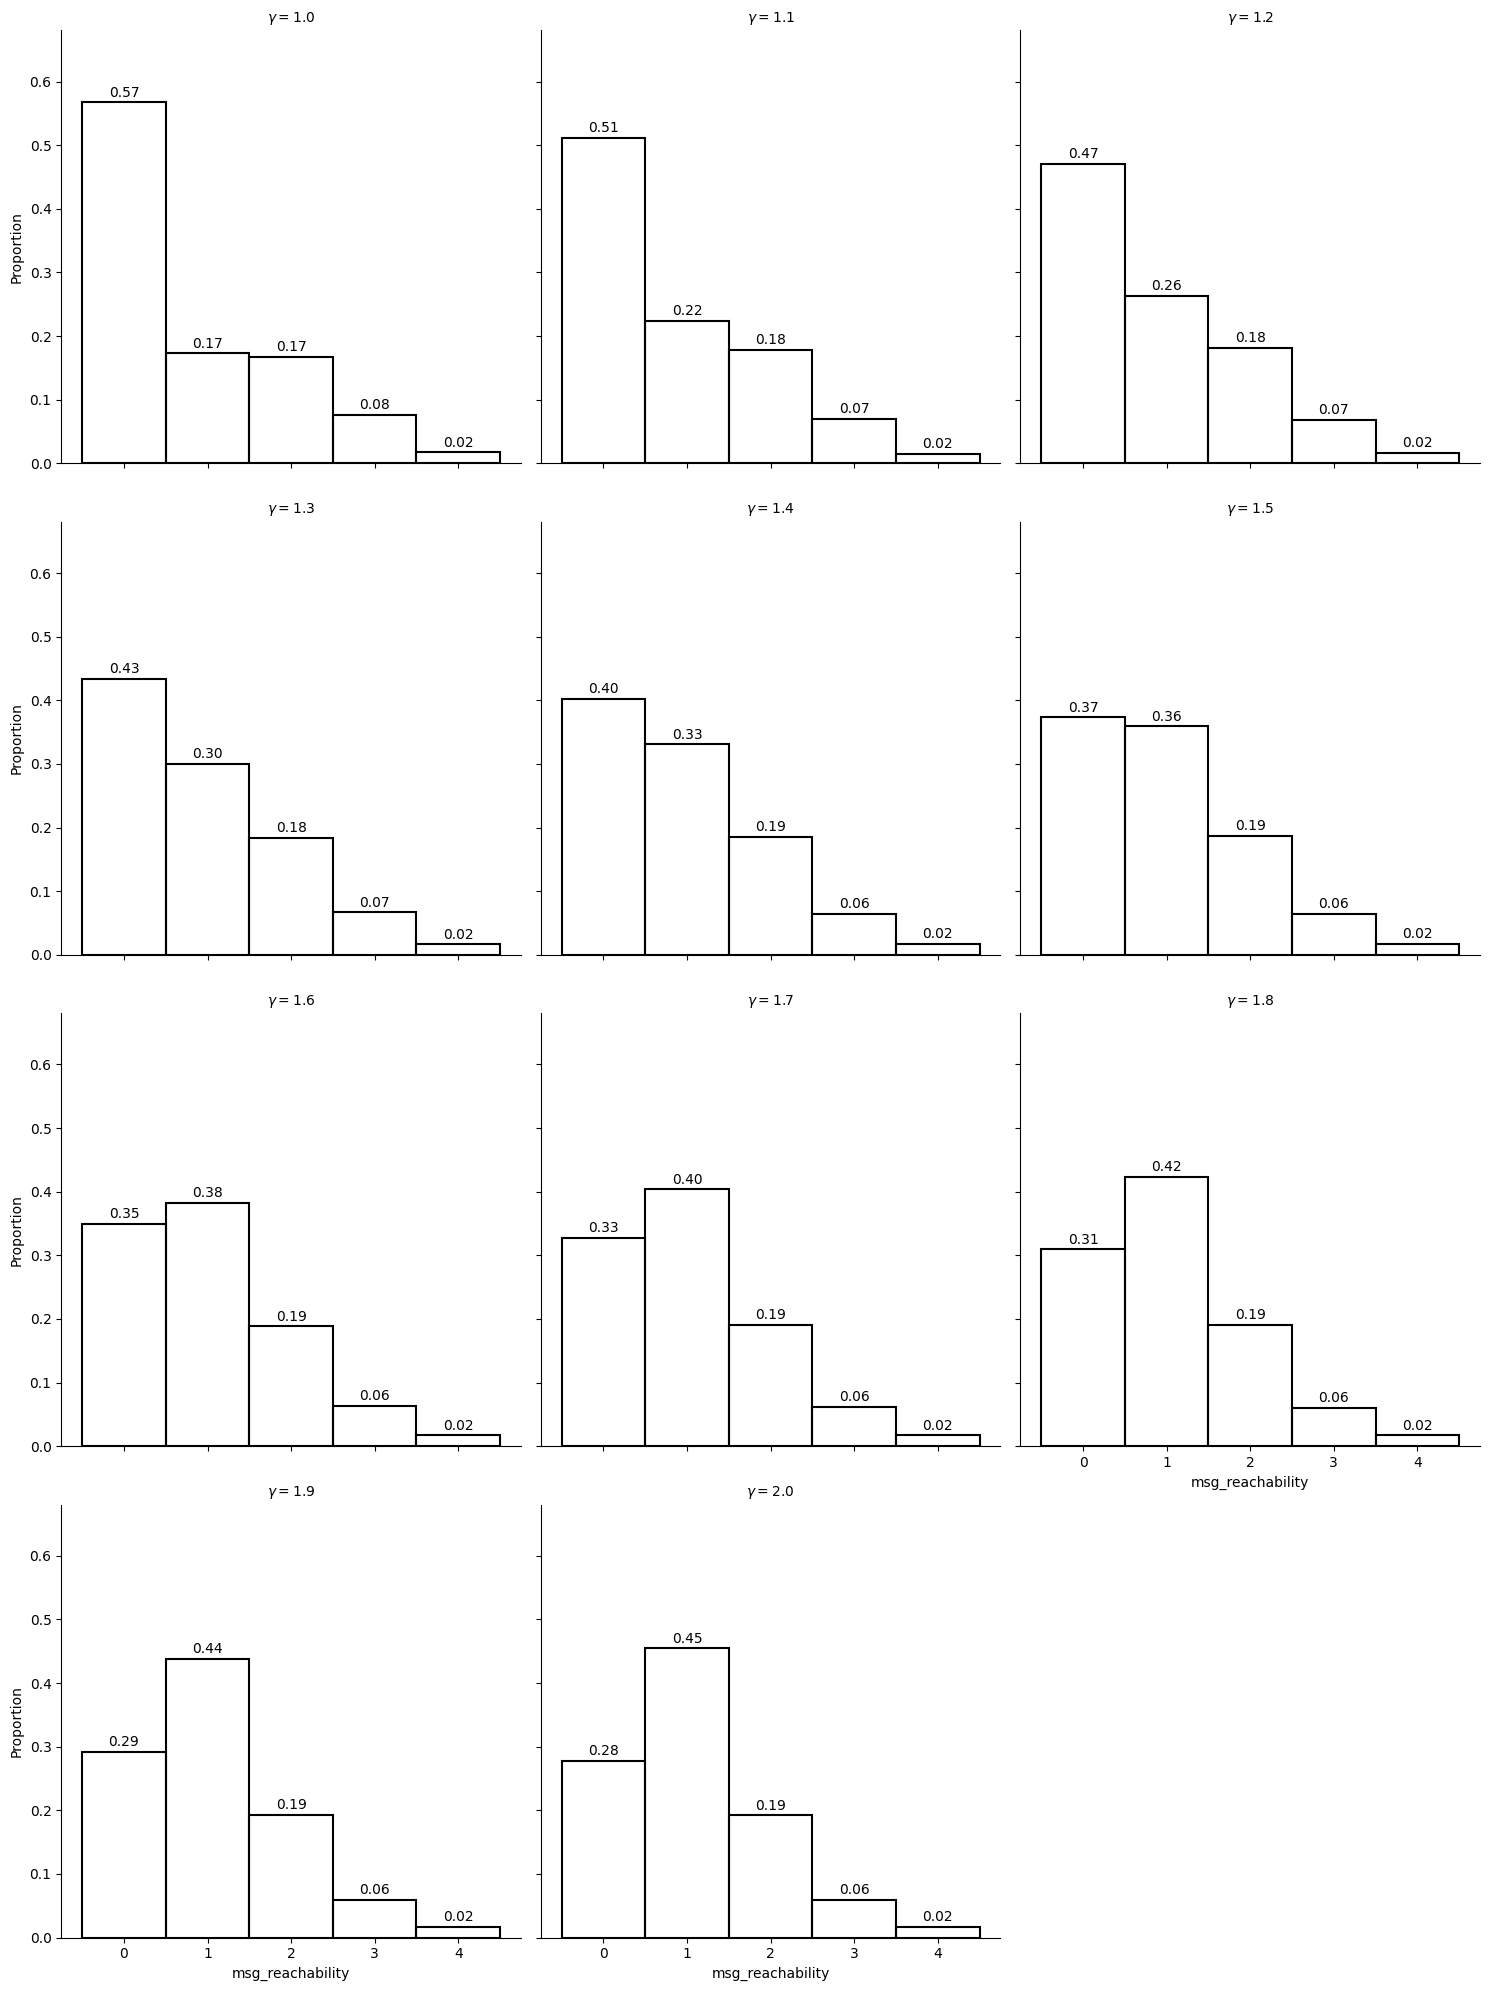

In [45]:
data = filter_min_parameter(df, operator.ge)
data = process_parameter_dataset(data)

g = sns.displot(
    data,
    kind="hist",
    x="msg_reachability",
    col=parameter,
    col_wrap=3,
    discrete=True,
    stat="proportion",
    binrange=(0, 4),
    fill=False,
    color="black",
    common_norm=False,
)

g.set_titles(col_template=f"${parameter_symbol} = {{col_name}}$")

# Ref: https://stackoverflow.com/a/67561982
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0], fmt="%.2f", padding=2)
    ax.margins(y=0.2)

save_figure("outputs/message-reachability-trellis")

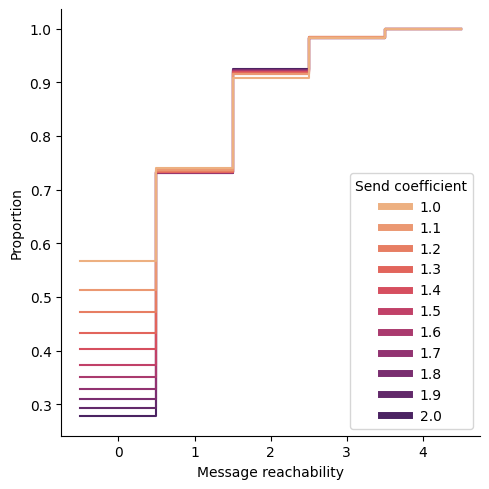

In [40]:
data = filter_min_parameter(df, operator.ge)
data = process_parameter_dataset(data)

# data = data.sample(fraction=0.01)

g = sns.displot(
    data,
    kind="hist",
    x="msg_reachability",
    stat="proportion",
    hue=parameter,
    discrete=True,
    cumulative=True,
    binrange=(0, 4),
    fill=False,
    element="step",
    common_norm=False,
    palette="flare",
    facet_kws={"legend_out": False},
)

g.set_xlabels("Message reachability")
g.legend.set_title(parameter_title)
set_legend_line_width(g, 5)

save_figure("outputs/message-reachability-histogram")

In [5]:
cols = {
    "exposure_score": "Exposure score",
    "score_diff": "Score difference",
    "n_contacts": "Contacts",
    "msg_reachability": " Message reachability",
    "n_influences": "Influences",
    "n_receives": "Receives",
    "n_influenced": "Influenced",
    "n_updates": "Updates",
}

data = filter_min_parameter(df, operator.eq)
data = process_parameter_dataset(data)
data = data.select(cols)

corr = data.rename(cols).to_pandas().corr("spearman")

shape = (len(cols), len(cols))
coeffs = np.zeros(shape)
ps = np.zeros(shape)

for (x_i, x_col), (y_i, y_col) in itertools.product(enumerate(cols), repeat=2):
    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()
    coeffs[x_i, y_i], ps[x_i, y_i] = stats.spearmanr(x, y)

ps.max()

1.0897315587796075e-163

Max p-value: 1.0897315587796075e-163


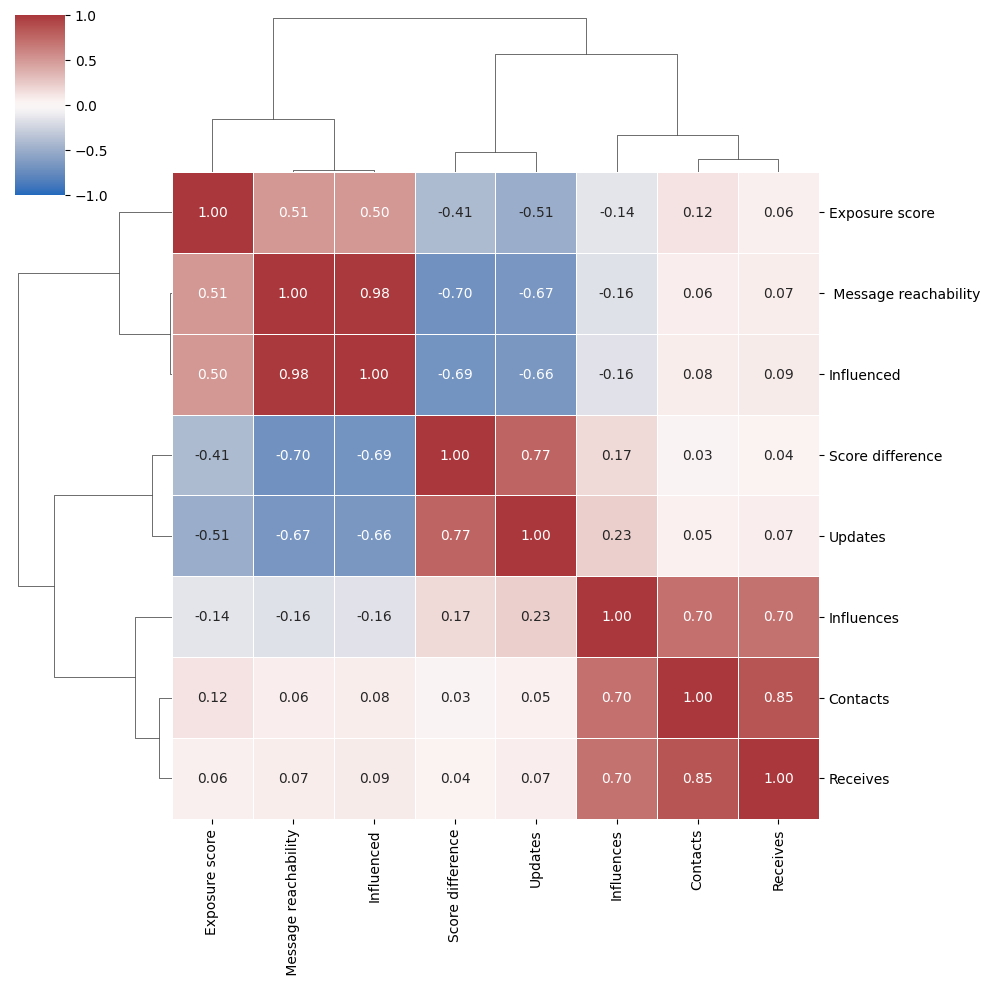

In [67]:
cols = {
    "exposure_score": "Exposure score",
    "score_diff": "Score difference",
    "n_contacts": "Contacts",
    "msg_reachability": " Message reachability",
    "n_influences": "Influences",
    "n_receives": "Receives",
    "n_influenced": "Influenced",
    "n_updates": "Updates",
}

parameter_value = min_parameter

data = df.filter(pl.col(parameter) == parameter_value)
data = process_parameter_dataset(data)
data = data.select(cols)

corr = data.rename(cols).to_pandas().corr("spearman")

shape = (len(cols), len(cols))
coeffs = np.zeros(shape)
ps = np.zeros(shape)

for (x_i, x_col), (y_i, y_col) in itertools.product(enumerate(cols), repeat=2):
    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()
    coeffs[x_i, y_i], ps[x_i, y_i] = stats.spearmanr(x, y)

print(f"Max p-value: {ps.max()}")

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.clustermap(
    corr,
    annot=True,
    cmap="vlag",
    center=0,
    vmin=-1,
    vmax=1,
    fmt=".2f",
    linewidths=0.5,
)

save_figure(f"outputs/correlation-clustermap-{parameter_value}")

Max p-value: 0.009257301655696793


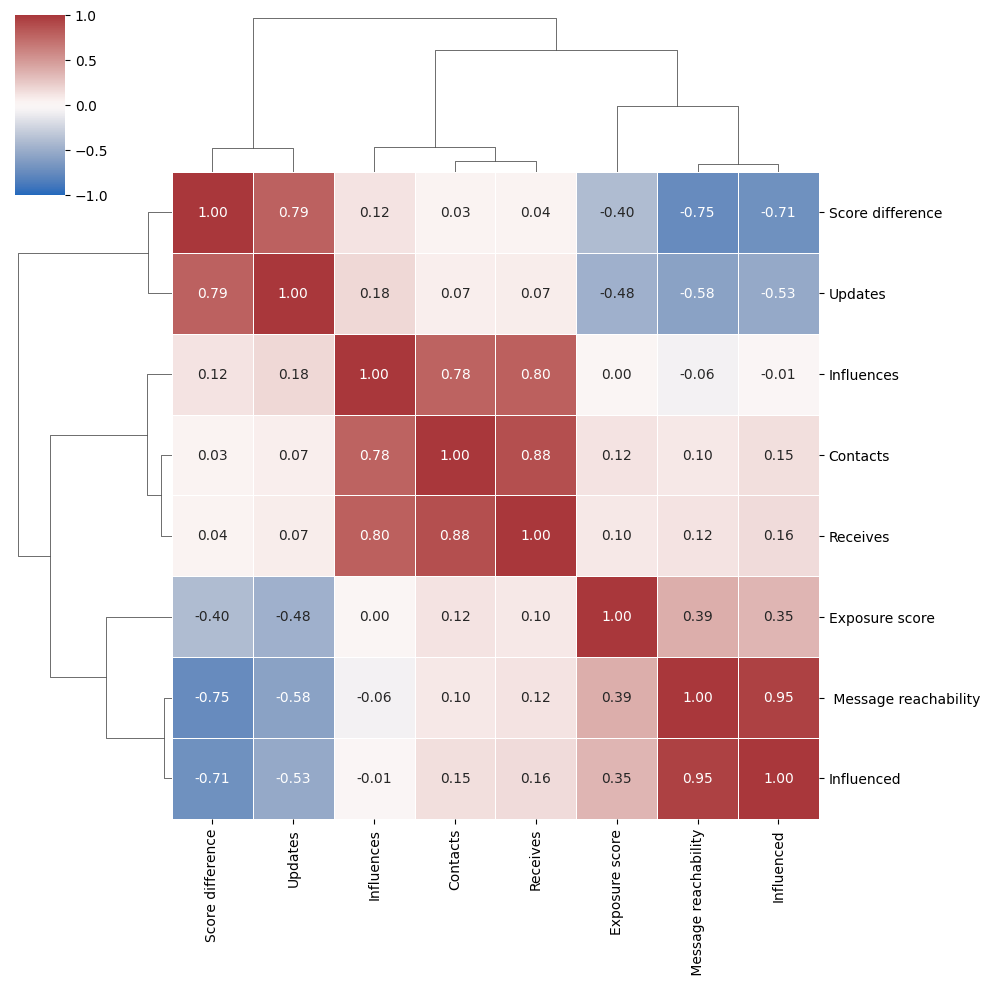

In [69]:
cols = {
    "exposure_score": "Exposure score",
    "score_diff": "Score difference",
    "n_contacts": "Contacts",
    "msg_reachability": " Message reachability",
    "n_influences": "Influences",
    "n_receives": "Receives",
    "n_influenced": "Influenced",
    "n_updates": "Updates",
}

parameter_value = 1.5

data = df.filter(pl.col(parameter) == parameter_value)
data = process_parameter_dataset(data)
data = data.select(cols)

corr = data.rename(cols).to_pandas().corr("spearman")

shape = (len(cols), len(cols))
coeffs = np.zeros(shape)
ps = np.zeros(shape)

for (x_i, x_col), (y_i, y_col) in itertools.product(enumerate(cols), repeat=2):
    x = data[x_col].to_numpy()
    y = data[y_col].to_numpy()
    coeffs[x_i, y_i], ps[x_i, y_i] = stats.spearmanr(x, y)

print(f"Max p-value: {ps.max()}")

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.clustermap(
    corr,
    annot=True,
    cmap="vlag",
    center=0,
    vmin=-1,
    vmax=1,
    fmt=".2f",
    linewidths=0.5,
)

save_figure(f"outputs/correlation-clustermap-{parameter_value}")

In [70]:
coeffs

array([[ 1.        , -0.40381206,  0.12495156,  0.38564633,  0.00290957,
         0.09757187,  0.34672531, -0.48158154],
       [-0.40381206,  1.        ,  0.03217517, -0.74657707,  0.12149878,
         0.03755396, -0.7109066 ,  0.78699176],
       [ 0.12495156,  0.03217517,  1.        ,  0.0961202 ,  0.78067713,
         0.87501482,  0.14673807,  0.06638818],
       [ 0.38564633, -0.74657707,  0.0961202 ,  1.        , -0.06302884,
         0.1215793 ,  0.94731473, -0.57898455],
       [ 0.00290957,  0.12149878,  0.78067713, -0.06302884,  1.        ,
         0.795795  , -0.00594805,  0.17769267],
       [ 0.09757187,  0.03755396,  0.87501482,  0.1215793 ,  0.795795  ,
         1.        ,  0.1630135 ,  0.07465047],
       [ 0.34672531, -0.7109066 ,  0.14673807,  0.94731473, -0.00594805,
         0.1630135 ,  1.        , -0.53058896],
       [-0.48158154,  0.78699176,  0.06638818, -0.57898455,  0.17769267,
         0.07465047, -0.53058896,  1.        ]])

### Tolerance

In [ ]:
df = load_dataset("tolerance")

In [ ]:
results = compute_accuracy_results(
    process_parameter_dataset(df),
    parameter="tolerance",
    percentiles=[0, 0.01, 0.1, 1],
)

In [ ]:
data = df
data = data.with_columns(pl.col("n_receives").list.sum())
data = data.with_columns(
    normalized("n_receives", by="max")
    .over("dataset_id", "network_id", "score_source")
    .alias("n_receives_norm")
)
percentiles = results.percentiles
data = data.join(percentiles, on="tolerance")

g = sns.FacetGrid(
    data.to_pandas(),
    hue="tolerance",
    height=4,
    aspect=2,
    sharex=False,
    sharey=False,
)

g.map_dataframe(sns.boxplot, "tolerance", "n_receives_norm")
g.map_dataframe(sns.pointplot, "tolerance", "0")
g.set_axis_labels("Tolerance", "Proportion")
g.add_legend()

plt.show()

## Experiment 2: Runtime baseline

**Objective**: Determine if the runtime across distribution types is the same.

In [21]:
df = load_dataset("runtime-baseline")
df = process_runtime_dataset(df)

In [23]:
data = compute_runtime_validity_results(df)
data = format_network_types(data)
data

network_type,count,proportion
str,u32,f64
"""Barabasi-Albert""",40,1.0
"""Erdös–Rényi""",40,1.0
"""Random regular""",40,1.0
"""Watts-Strogatz""",40,1.0



ANOVA assumes normality. Use the Shapiro-Wilks test.

https://en.wikipedia.org/wiki/Analysis_of_variance#Assumptions

https://www.pythonfordatascience.org/parametric-assumptions-python

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html#scipy.stats.shapiro

In [3]:
apply_hypothesis_test(df, stats.shapiro, by_distributions=True)

ShapiroResult(statistic=0.6719801789018303, pvalue=2.0429301226064135e-17)

In [4]:
apply_hypothesis_test(df, stats.shapiro, by_distributions=True, by_network_type=True)

{'BarabasiAlbert': ShapiroResult(statistic=0.6455841858114171, pvalue=1.3871243031399366e-08),
 'GnmRandom': ShapiroResult(statistic=0.4722427270825328, pvalue=8.131432237889303e-11),
 'RandomRegular': ShapiroResult(statistic=0.5834436164177572, pvalue=1.872371357241336e-09),
 'WattsStrogatz': ShapiroResult(statistic=0.43728166802888535, pvalue=3.332332165092599e-11)}

The $p$ values are very low, which suggests the null hypothesis of normality is rejected.

To use non-parametric ANOVA, we must still ensure the homoscedasticity assumption holds.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fligner.html

In [5]:
apply_hypothesis_test(df, stats.fligner, by_distributions=True)

FlignerResult(statistic=2.2763249122756135, pvalue=0.9429784063064716)

In [6]:
apply_hypothesis_test(df, stats.fligner, by_distributions=True, by_network_type=True)

{'BarabasiAlbert': FlignerResult(statistic=4.608714192501368, pvalue=0.7075897925246313),
 'GnmRandom': FlignerResult(statistic=4.877621552929998, pvalue=0.6748947081529909),
 'RandomRegular': FlignerResult(statistic=3.971899028233328, pvalue=0.7830083542754538),
 'WattsStrogatz': FlignerResult(statistic=2.2685059085200354, pvalue=0.9434980918897997)}

The $p$ value is high, which indicates the null hypothesis of homoscedasticity cannot be rejected.

The Kruskal-Wallis test is the non-parametric equivalent of one-way ANOVA.

https://en.wikipedia.org/wiki/Kruskal–Wallis_test

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal

In [7]:
apply_hypothesis_test(df, stats.kruskal, by_distributions=True)

KruskalResult(statistic=7.030418187414842, pvalue=0.4257196188778194)

In [8]:
apply_hypothesis_test(df, stats.kruskal, by_distributions=True, by_network_type=True)

{'BarabasiAlbert': KruskalResult(statistic=5.240544856740269, pvalue=0.63063439449162),
 'GnmRandom': KruskalResult(statistic=3.230925507900674, pvalue=0.8628497317188261),
 'RandomRegular': KruskalResult(statistic=3.021859154929603, pvalue=0.8829727404160816),
 'WattsStrogatz': KruskalResult(statistic=5.970614777213772, pvalue=0.543184692346687)}

A high $p$ value indicates that the null hypothesis cannot be rejected.

**Conclusion:** There is no statistically significant difference in runtime across data distributions.

## Runtime experiment

In [8]:
df = load_dataset("runtime")
df = process_runtime_dataset(df)

valid = df.filter(valid=True)
invalid = df.filter(valid=False)

In [9]:
data = compute_runtime_validity_results(df)
data = format_network_types(data)
data

network_type,count,proportion
str,u32,f64
"""Barabasi-Albert""",484,0.968
"""Erdös–Rényi""",491,0.982
"""Random regular""",493,0.986
"""Watts-Strogatz""",487,0.974


In [10]:
save_table(data, "outputs/runtime-validity")

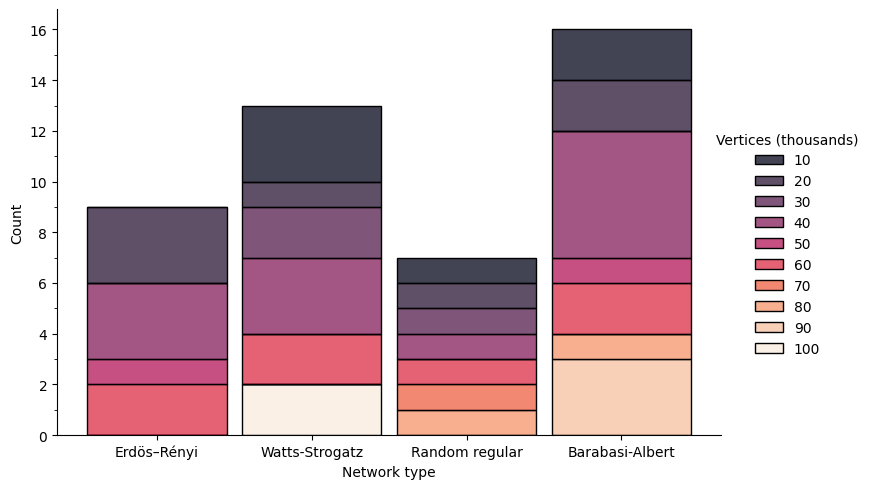

In [11]:
data = binned(invalid, col='n_nodes', scale=10_000, rescale=10)
data = format_network_types(data)

g = sns.displot(
    data,
    kind="hist",
    stat="count",
    x="network_type",
    hue="binned_n_nodes",
    discrete=True,
    multiple="stack",
    aspect=1.5,
    palette="rocket",
    shrink=0.9,
)

g.set_axis_labels("Network type", "Count")
g.ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

g.legend.set_title("Vertices (thousands)")

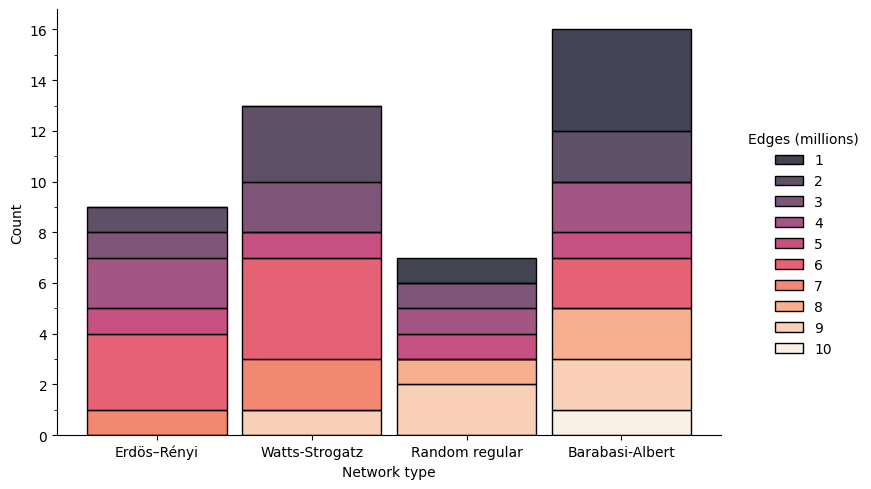

In [12]:
data = binned(invalid, col='n_edges', scale=1_000_000, rescale=False)
data = format_network_types(data)

g = sns.displot(
    data,
    kind="hist",
    stat="count",
    x="network_type",
    hue="binned_n_edges",
    discrete=True,
    multiple="stack",
    aspect=1.5,
    palette="rocket",
    shrink=0.9,
)

g.set_axis_labels("Network type", "Count")
g.ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
g.legend.set_title("Edges (millions)")

In [13]:
data = valid
x = data["n_nodes", "n_edges"].to_numpy()
y = data["msg_runtime"].to_numpy()
pg.linear_regression(x, y, alpha=0.05, relimp=True)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,-34.883897,3.190455e+00,-10.933831,4.750138e-27,0.673911,0.673576,-41.140954,-28.626840,NaN,NaN
1,x1,-0.000184,3.838380e-05,-4.799528,1.711184e-06,0.673911,0.673576,-0.000260,-0.000109,0.003833,0.568797
2,x2,0.000024,3.834697e-07,63.334281,0.000000e+00,0.673911,0.673576,0.000024,0.000025,0.670077,99.431203


In [14]:
data = valid
x = data["n_edges"].to_numpy()
y = data["msg_runtime"].to_numpy()
pg.linear_regression(x, y, alpha=0.05, relimp=True)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,-45.058927,2.397648e+00,-18.792970,1.475980e-72,0.670062,0.669893,-49.761145,-40.356709,NaN,NaN
1,x1,0.000024,3.856269e-07,62.978572,0.000000e+00,0.670062,0.669893,0.000024,0.000025,0.670062,100.0


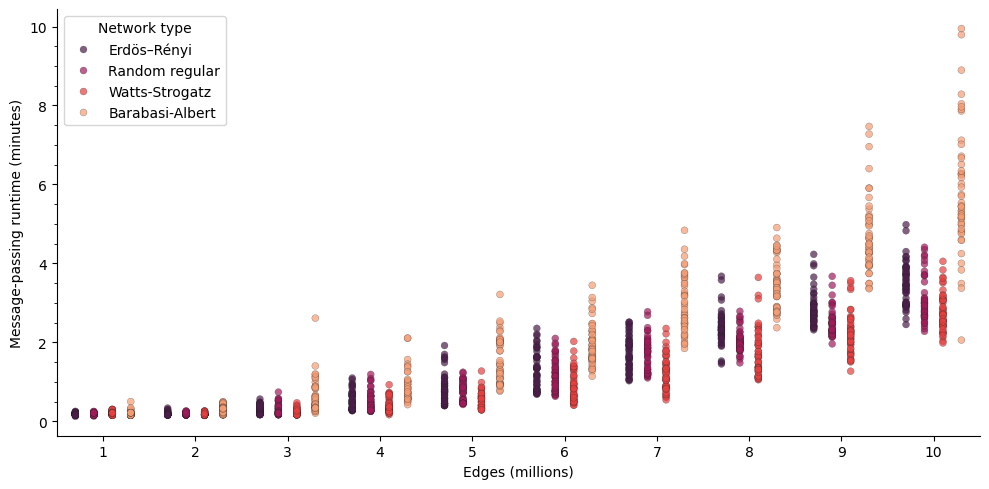

In [15]:
data = binned(valid, col='n_edges', scale=1_000_000, rescale=False)
data = data.with_columns(pl.col("msg_runtime") / 60)
data = format_network_types(data)

g = sns.catplot(
    data,
    x="binned_n_edges",
    y="msg_runtime",
    hue="network_type",
    kind="strip",
    dodge=True,
    jitter=0,
    palette="rocket",
    linewidth=0.2,
    alpha=0.7,
    legend_out=False,
    aspect=2,
)

g.ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
g.legend.set_title("Network type")
g.set_axis_labels("Edges (millions)", "Message-passing runtime (minutes)")

save_figure("outputs/runtime")